# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'sklearn': '1.0.0',
    'matplotlib': '3.4.3',
    'torch': '1.9.0',
}
check_packages(d)

[OK] Your Python version is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
[OK] numpy 1.23.0
[OK] scipy 1.8.1
[OK] sklearn 1.1.1
[OK] matplotlib 3.5.2
[OK] torch 1.11.0+cu102


# Chapter 12: Parallelizing Neural Network Training with PyTorch  (Part 2/2)


- [Building an NN model in PyTorch](#Building-an-NN-model-in-PyTorch)
  - [The PyTorch neural network module (torch.nn)](#The-PyTorch-neural-network-module-(torch.nn))
  - [Building a linear regression model](#Building-a-linear-regression-model)
  - [Model training via the torch.nn and torch.optim modules](#Model-training-via-the-torch.nn-and-torch.optim-modules)
  - [Building a multilayer perceptron for classifying flowers in the Iris dataset](#Building-a-multilayer-perceptron-for-classifying-flowers-in-the-Iris-dataset)
  - [Evaluating the trained model on the test dataset](#Evaluating-the-trained-model-on-the-test-dataset)
  - [Saving and reloading the trained model](#Saving-and-reloading-the-trained-model)
- [Choosing activation functions for multilayer neural
networks](#Choosing-activation-functions-for-multilayer-neural-networks)
  - [Logistic function recap](#Logistic-function-recap)
  - [Estimating class probabilities in multiclass classification via the softmax function](#Estimating-class-probabilities-in-multiclass-classification-via-the-softmax-function)
  - [Broadening the output spectrum using a hyperbolic tangent](#Broadening-the-output-spectrum-using-a-hyperbolic-tangent)
  - [Rectified linear unit activation](#Rectified-linear-unit-activation)
- [Summary](#Summary)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [3]:
from IPython.display import Image as IPythonImage
%matplotlib inline

## Building a neural network model in PyTorch

### The PyTorch neural network module (torch.nn)

### Building a linear regression model

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

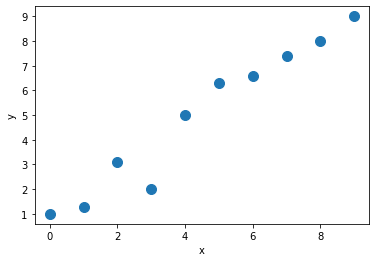

In [5]:
X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 
                    7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

#plt.savefig('figures/12_07.pdf')
plt.show()

In [6]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)

# On some computers the explicit cast to .float() is
# necessary
y_train = torch.from_numpy(y_train).float()

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [7]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)
 
def loss_fn(input, target):
    return (input-target).pow(2).mean()

def model(xb):
    return xb @ weight + bias

learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()

        with torch.no_grad():
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_()
            bias.grad.zero_()
 
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')
 

Epoch 0  Loss 45.0782
Epoch 10  Loss 26.4366
Epoch 20  Loss 1.5918
Epoch 30  Loss 14.1307
Epoch 40  Loss 11.6038
Epoch 50  Loss 6.3084
Epoch 60  Loss 0.6349
Epoch 70  Loss 3.1374
Epoch 80  Loss 1.9999
Epoch 90  Loss 0.3133
Epoch 100  Loss 0.7653
Epoch 110  Loss 1.0039
Epoch 120  Loss 0.0235
Epoch 130  Loss 0.5176
Epoch 140  Loss 0.0759
Epoch 150  Loss 1.8789
Epoch 160  Loss 0.0008
Epoch 170  Loss 0.0866
Epoch 180  Loss 0.0646
Epoch 190  Loss 0.0011


Final Parameters: 2.6696107387542725 4.879678249359131


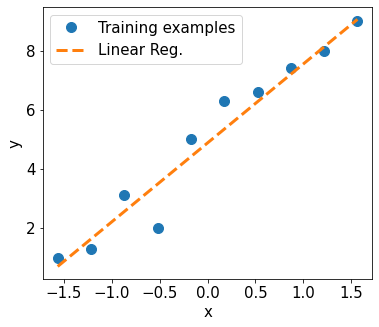

In [8]:
print('Final Parameters:', weight.item(), bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('figures/12_08.pdf')

plt.show()

### Model training via the torch.nn and torch.optim modules

In [9]:
import torch.nn as nn

input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch)[:, 0] 

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 24.6684
Epoch 10  Loss 29.1377
Epoch 20  Loss 20.9207
Epoch 30  Loss 0.1257
Epoch 40  Loss 12.4922
Epoch 50  Loss 1.7845
Epoch 60  Loss 7.6425
Epoch 70  Loss 2.5606
Epoch 80  Loss 0.0157
Epoch 90  Loss 0.7548
Epoch 100  Loss 0.8412
Epoch 110  Loss 0.4923
Epoch 120  Loss 0.0823
Epoch 130  Loss 0.0794
Epoch 140  Loss 0.0891
Epoch 150  Loss 0.0973
Epoch 160  Loss 0.1043
Epoch 170  Loss 0.1103
Epoch 180  Loss 0.0009
Epoch 190  Loss 0.0764


Final Parameters: 2.6496422290802 4.87706995010376


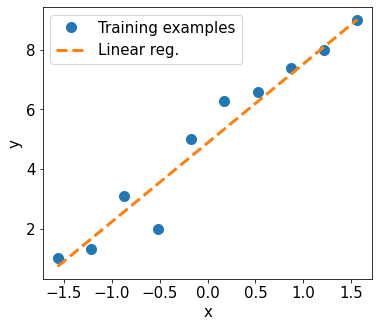

In [10]:
print('Final Parameters:', model.weight.item(), model.bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('ch12-linreg-2.pdf')

plt.show()


## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [12]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

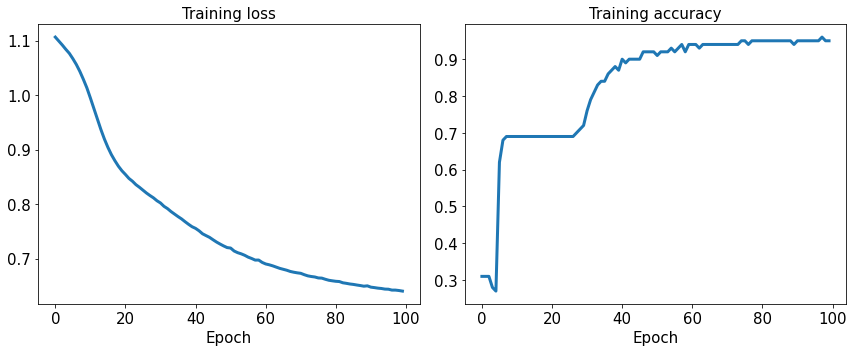

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()

### Evaluating the trained model on the test dataset

In [16]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')


Test Acc.: 0.9800


### Saving and reloading the trained model

In [17]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [18]:
model_new = torch.load(path)
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [19]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [20]:
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [21]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))


<All keys matched successfully>

## Choosing activation functions for multilayer neural networks


### Logistic function recap

In [22]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w):.3f}') 

P(y=1|x) = 0.888


In [23]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [24]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class) 

Predicted class label: 0


### Estimating class probabilities in multiclass classification via the softmax function

In [25]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [26]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

### Broadening the output spectrum using a hyperbolic tangent

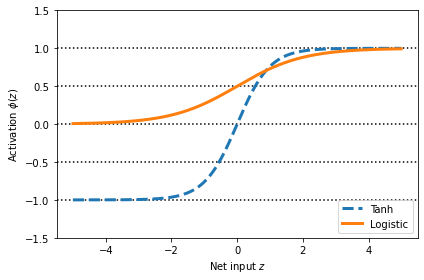

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

#plt.savefig('figures/12_10.pdf')
plt.show()

In [28]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [29]:
torch.tanh(torch.from_numpy(z))
 

tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [30]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [31]:
torch.sigmoid(torch.from_numpy(z))

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

### Rectified linear unit activation

In [32]:
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)

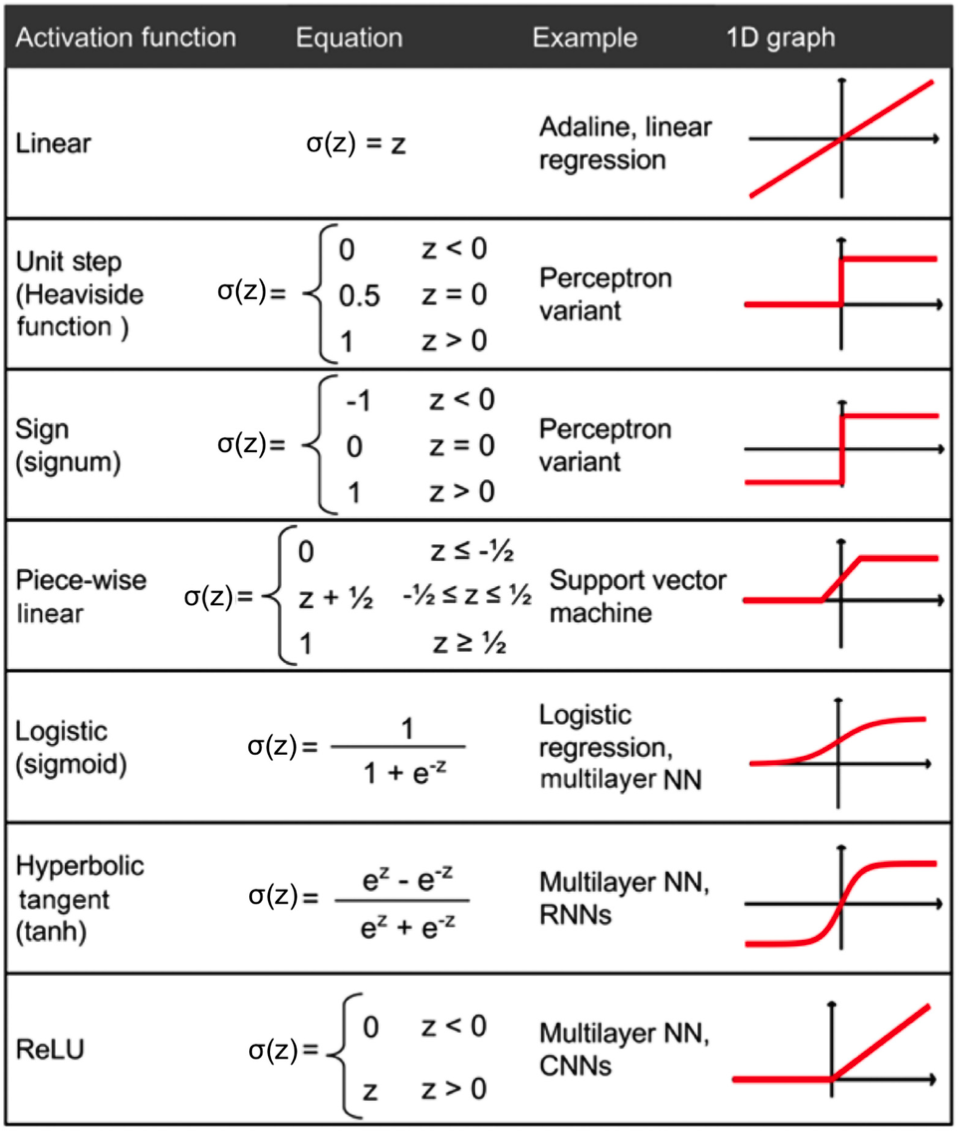

In [33]:
IPythonImage(filename='figures/12_11.png', width=500)

## Summary

---

Readers may ignore the next cell.

In [34]:
! python ../.convert_notebook_to_script.py --input ch12_part2.ipynb --output ch12_part2.py

[NbConvertApp] Converting notebook ch12_part2.ipynb to script
[NbConvertApp] Writing 12165 bytes to ch12_part2.py
